In [2]:
!pip install torchdiffeq systems

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from torchdiffeq import odeint
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler

Epoch 0, Loss = 1.356709
Epoch 100, Loss = 0.762639
Epoch 200, Loss = 0.120283
Epoch 300, Loss = 0.029927
Epoch 400, Loss = 0.023548
Epoch 500, Loss = 0.020552
Epoch 600, Loss = 0.006001
Epoch 700, Loss = 0.016721
Epoch 800, Loss = 0.031204
Epoch 900, Loss = 0.006346
Epoch 1000, Loss = 0.005028
Epoch 1100, Loss = 0.029428
Epoch 1200, Loss = 0.004268
Epoch 1300, Loss = 0.004627
Epoch 1400, Loss = 0.058169
Epoch 1500, Loss = 0.022523
Epoch 1600, Loss = 0.003525
Epoch 1700, Loss = 0.005511
Epoch 1800, Loss = 0.009126
Epoch 1900, Loss = 0.001878


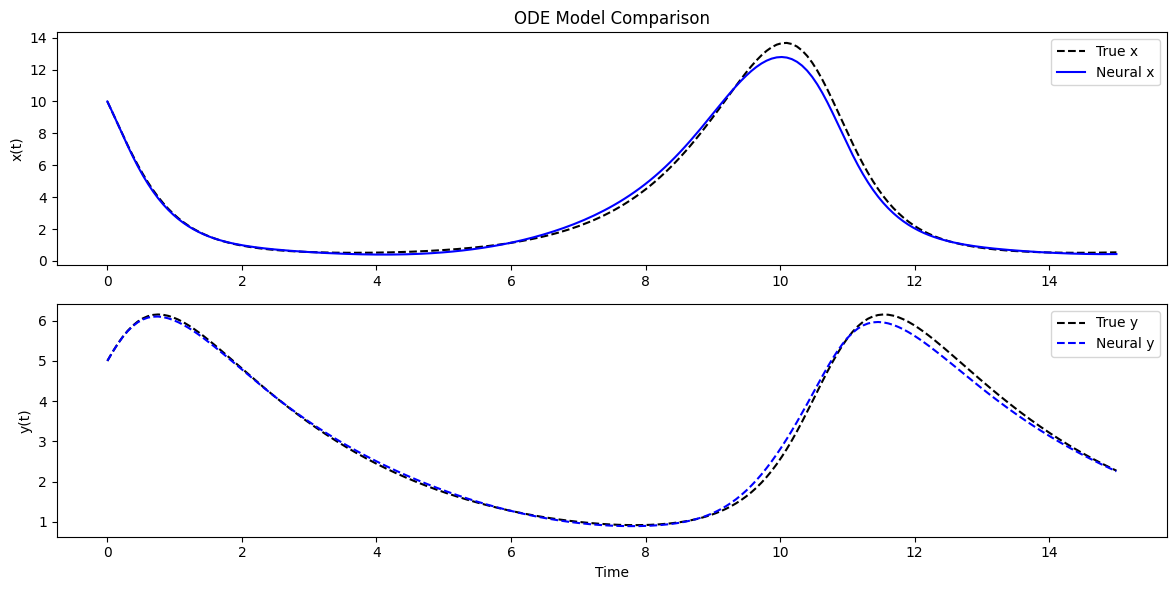

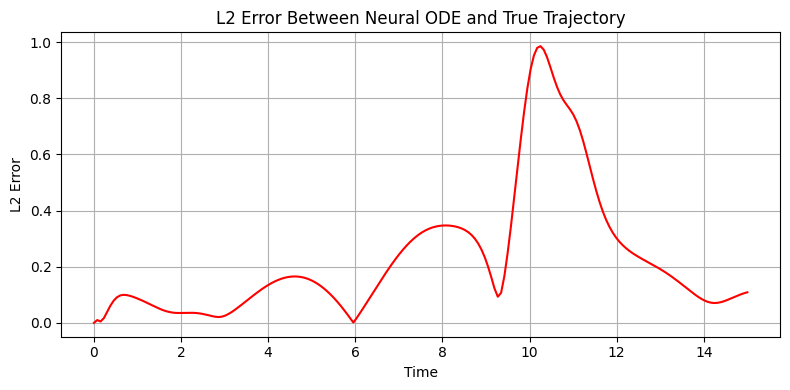

In [40]:
# Ground truth model
def lotka_volterra(t, z, alpha=1.1, beta=0.4, delta=0.1, gamma=0.4):
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Generate synthetic data
def generate_data(true_params, z0, t_eval):
    sol = solve_ivp(lambda t, z: lotka_volterra(t, z, *true_params),
                    [t_eval[0], t_eval[-1]], z0, t_eval=t_eval, rtol=1e-8, atol=1e-8)
    return torch.tensor(sol.t, dtype=torch.float32), torch.tensor(sol.y.T, dtype=torch.float32)

# Neural ODE Model
class NeuralODE(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, t, z):
        return self.net(z)

# Training loop
def train(model, t_eval, z_data, n_epochs=2000, lr=0.01):
    scaler = StandardScaler()
    z_data_np = z_data.numpy()
    z_data_scaled = scaler.fit_transform(z_data_np)
    z_data_scaled = torch.tensor(z_data_scaled, dtype=torch.float32)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        z0 = z_data_scaled[0]
        z_pred = odeint(model, z0, t_eval, method='dopri5')
        loss = loss_fn(z_pred, z_data_scaled)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.6f}")
    return model, scaler

# Main
if __name__ == "__main__":
    true_params = [1.1, 0.4, 0.1, 0.4]
    z0 = [10.0, 5.0]
    t_eval_np = np.linspace(0, 15, 200)
    t_eval, z_data = generate_data(true_params, z0, t_eval_np)

    # Train Neural ODE
    model_neural = NeuralODE()
    trained_neural, scaler = train(model_neural, t_eval, z_data)

    # Visualize
    with torch.no_grad():
        z0_scaled = torch.tensor(scaler.transform(z_data[[0]].numpy()), dtype=torch.float32)[0]
        pred_neural_scaled = odeint(trained_neural, z0_scaled, t_eval, method='dopri5')
        pred_neural = torch.tensor(scaler.inverse_transform(pred_neural_scaled.numpy()), dtype=torch.float32)

    plt.figure(figsize=(12, 6))

    # Subplot for x(t)
    plt.subplot(2, 1, 1)
    plt.plot(t_eval.numpy(), z_data[:, 0], 'k', label='True x')
    plt.plot(t_eval.numpy(), pred_neural[:, 0], 'b--', label='Neural x')
    plt.ylabel("x(t)")
    plt.title("ODE Model Comparison")
    plt.legend()

    # Subplot for y(t)
    plt.subplot(2, 1, 2)
    plt.plot(t_eval.numpy(), z_data[:, 1], 'k', label='True y')
    plt.plot(t_eval.numpy(), pred_neural[:, 1], 'b--', label='Neural y')
    plt.xlabel("Time")
    plt.ylabel("y(t)")
    plt.legend()

    plt.tight_layout()
    plt.show()
        # Compute L2 error at each time step
    l2_error = np.linalg.norm(pred_neural - z_data, axis=1)  # shape: (num_timesteps,)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(t_eval.numpy(), l2_error, 'r')
    plt.xlabel("Time")
    plt.ylabel("L2 Error")
    plt.title("L2 Error Between Neural ODE and True Trajectory")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Epoch 0, Loss = 54.378616
Epoch 200, Loss = 0.974369
Epoch 400, Loss = 0.869492
Epoch 600, Loss = 0.824012
Epoch 800, Loss = 0.798133
Epoch 1000, Loss = 0.780812
Epoch 1200, Loss = 0.768078
Epoch 1400, Loss = 0.758155
Epoch 1600, Loss = 0.750802
Epoch 1800, Loss = 0.744981


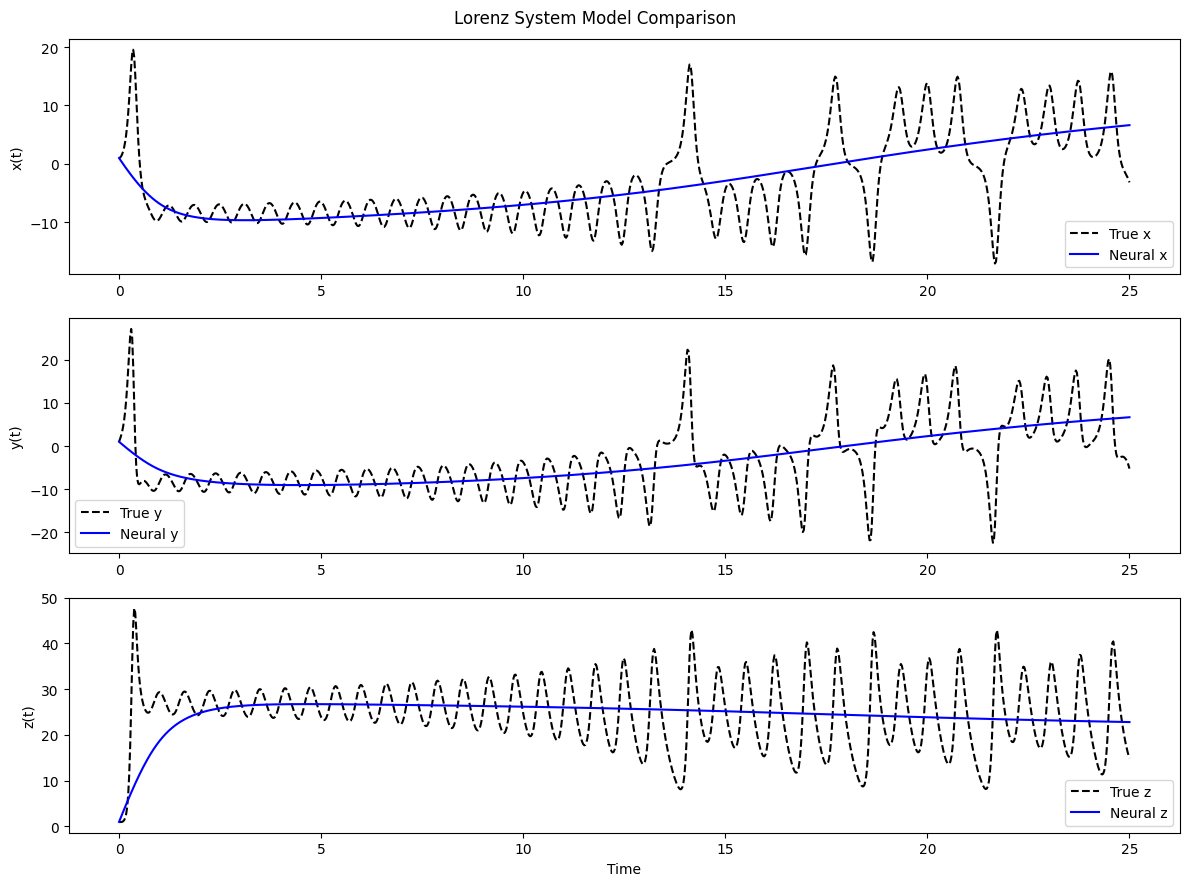

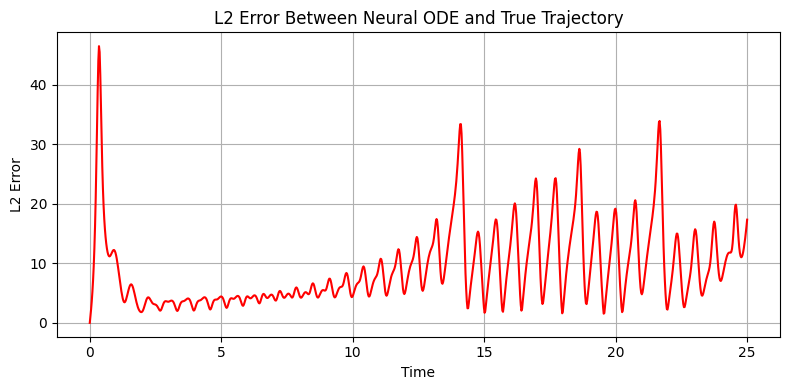

In [34]:
# Ground truth Lorenz system
def lorenz(t, z, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z_ = z
    dxdt = sigma * (y - x)
    dydt = x * (rho - z_) - y
    dzdt = x * y - beta * z_
    return [dxdt, dydt, dzdt]

# Generate synthetic data from Lorenz system
def generate_data(true_params, z0, t_eval):
    sol = solve_ivp(lambda t, z: lorenz(t, z, *true_params),
                    [t_eval[0], t_eval[-1]], z0, t_eval=t_eval, rtol=1e-8, atol=1e-8)
    return torch.tensor(sol.t, dtype=torch.float32), torch.tensor(sol.y.T, dtype=torch.float32)

# Neural ODE model for 3D Lorenz system
class NeuralODE(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, t, z):
        return self.net(z)

# Training loop with normalization
def train(model, t_eval, z_data, n_epochs=2000, lr=1e-3):
    scaler = StandardScaler()
    z_data_np = z_data.numpy()
    z_data_scaled = scaler.fit_transform(z_data_np)
    z_data_scaled = torch.tensor(z_data_scaled, dtype=torch.float32)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        z0 = z_data_scaled[0]
        z_pred = odeint(model, z0, t_eval, method='dopri5')
        loss = loss_fn(z_pred, z_data_scaled)
        loss.backward()
        optimizer.step()
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.6f}")
    return model, scaler

# Main execution
if __name__ == "__main__":
    true_params = [10.0, 28.0, 8/3]
    z0 = [1.0, 1.0, 1.0]  # Classic chaotic initial condition
    t_eval_np = np.linspace(0, 25, 1000)  # Denser grid to capture chaos
    t_eval, z_data = generate_data(true_params, z0, t_eval_np)

    # Train Neural ODE
    model_neural = NeuralODE()
    trained_neural, scaler = train(model_neural, t_eval, z_data)

    # Predict with trained model
    with torch.no_grad():
        z0_scaled = torch.tensor(scaler.transform(z_data[[0]].numpy()), dtype=torch.float32)[0]
        pred_neural_scaled = odeint(trained_neural, z0_scaled, t_eval, method='dopri5')
        pred_neural = torch.tensor(scaler.inverse_transform(pred_neural_scaled.numpy()), dtype=torch.float32)

    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(12, 9))

    axs[0].plot(t_eval.numpy(), z_data[:, 0], 'k--', label='True x')
    axs[0].plot(t_eval.numpy(), pred_neural[:, 0], 'b', label='Neural x')
    axs[0].set_ylabel("x(t)")
    axs[0].legend()

    axs[1].plot(t_eval.numpy(), z_data[:, 1], 'k--', label='True y')
    axs[1].plot(t_eval.numpy(), pred_neural[:, 1], 'b', label='Neural y')
    axs[1].set_ylabel("y(t)")
    axs[1].legend()

    axs[2].plot(t_eval.numpy(), z_data[:, 2], 'k--', label='True z')
    axs[2].plot(t_eval.numpy(), pred_neural[:, 2], 'b', label='Neural z')
    axs[2].set_xlabel("Time")
    axs[2].set_ylabel("z(t)")
    axs[2].legend()

    plt.suptitle("Lorenz System Model Comparison")
    plt.tight_layout()
    plt.show()

    # Compute L2 error at each time step
    l2_error = np.linalg.norm(pred_neural - z_data, axis=1)  # shape: (num_timesteps,)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(t_eval.numpy(), l2_error, 'r')
    plt.xlabel("Time")
    plt.ylabel("L2 Error")
    plt.title("L2 Error Between Neural ODE and True Trajectory")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


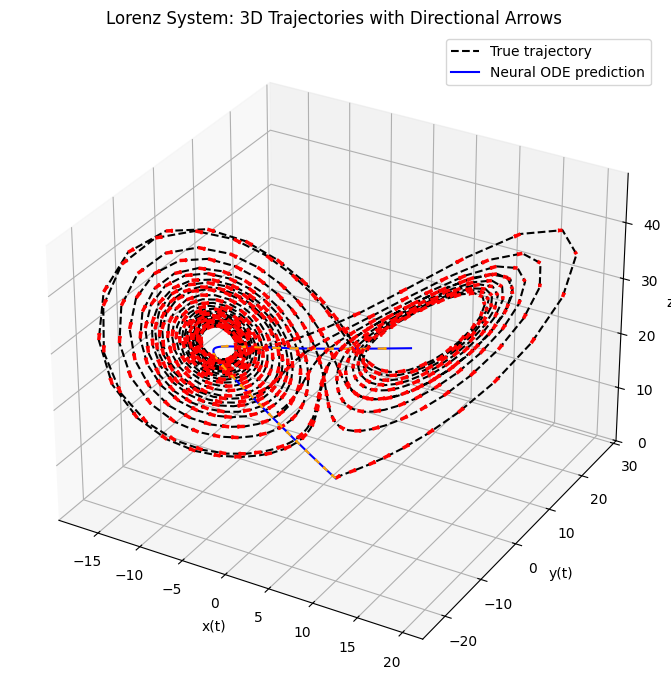

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


def sample_arrows_by_distance(traj, min_dist):
    """Return indices where the distance from the last arrow exceeds min_dist."""
    arrow_indices = [0]
    last = traj[0]
    for i in range(1, len(traj)):
        dist = np.linalg.norm(traj[i] - last)
        if dist >= min_dist:
            arrow_indices.append(i)
            last = traj[i]
    return arrow_indices

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


# Choose a minimum spacing between arrows
min_arrow_spacing = 2.0  # tweak as needed

# Get indices for arrow placement
arrow_indices_true = sample_arrows_by_distance(z_data, min_arrow_spacing)
arrow_indices_pred = sample_arrows_by_distance(pred_neural, min_arrow_spacing)

# Arrows for true trajectory
for i in arrow_indices_true[:-1]:
    p0 = z_data[i]
    p1 = z_data[i + 1]
    direction = p1 - p0
    ax.quiver(*p0, *direction, color='r', length=1.0, normalize=True, linewidth=2.5)

# Arrows for predicted trajectory
for i in arrow_indices_pred[:-1]:
    p0 = pred_neural[i]
    p1 = pred_neural[i + 1]
    direction = p1 - p0
    ax.quiver(*p0, *direction, color='orange', length=1, normalize=True, linewidth=1.5)

# Plot true trajectory
ax.plot(z_data[:, 0], z_data[:, 1], z_data[:, 2], 'k--', label='True trajectory')

# Plot neural ODE prediction
ax.plot(pred_neural[:, 0], pred_neural[:, 1], pred_neural[:, 2], 'b', label='Neural ODE prediction')

# Arrow settings
arrow_stride = 10  # frequency of arrows
scale = 10         # increase or decrease to lengthen/shorten arrows


# Axis labels
ax.set_xlabel("x(t)")
ax.set_ylabel("y(t)")
ax.set_zlabel("z(t)")

# Title and legend
ax.set_title("Lorenz System: 3D Trajectories with Directional Arrows")
ax.legend()

plt.tight_layout()
plt.show()
import numpy as np
